# Data Exploration

导出 `requirements.txt`

```
conda list --explicit > requirements.txt

```

# Dataset Structure

The dataset contains four directories:

- **`monet_tfrec`**: Contains painting images in TFRecord format. --> 300 pics with 256x256 resolution
- **`photo_tfrec`**: Contains photo images in TFRecord format. --> 7028 pics with 256x256 resolution
- **`monet_jpg`**: Contains the same painting images as `monet_tfrec` but in JPG format.
- **`photo_jpg`**: Contains the same photo images as `photo_tfrec` but in JPG format.


In [6]:
import os
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import time
import math
import random
import cv2
from IPython import display

In [ ]:
monet_tfrec = "../data/monet_tfrec"
MONET_FILENAMES = os.listdir(monet_tfrec)
MONET_PATHS = [os.path.join(monet_tfrec,filename) for filename in MONET_FILENAMES]

photo_tfrec = "../data/photo_tfrec"
PHOTO_FILENAMES = os.listdir(photo_tfrec)
PHOTO_PATHS = [os.path.join(photo_tfrec,filename) for filename in PHOTO_FILENAMES]

MONET_PATHS

['../gan-getting-started/monet_tfrec/monet04-60.tfrec',
 '../gan-getting-started/monet_tfrec/monet16-60.tfrec',
 '../gan-getting-started/monet_tfrec/monet00-60.tfrec',
 '../gan-getting-started/monet_tfrec/monet12-60.tfrec',
 '../gan-getting-started/monet_tfrec/monet08-60.tfrec']

In [ ]:
IMAGE_SIZE = [256, 256]
AUTOTUNE = tf.data.AUTOTUNE

def parse_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    # 像这样parse出来，是一个二进制图像数据，需要进一步decode
    # TFRecord format is a "simple format for storing a sequence of binary records" 
    image = example['image']
    image = tf.image.decode_jpeg(image, channels=3)
    # 进行一步归一化 [0, 255] -> [-1, 1]，适合GAN网络
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])    
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [ ]:
example_monet

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[-0.05882353, -0.01960784, -0.3333333 ],
         [-0.11372548, -0.02745098, -0.35686272],
         [-0.15294117, -0.00392157, -0.36470586],
         ...,
         [ 0.10588241,  0.13725495, -0.04313725],
         [ 0.05098045,  0.09019613, -0.09019607],
         [ 0.00392163,  0.04313731, -0.1372549 ]],

        [[-0.0745098 , -0.01960784, -0.34117645],
         [-0.09019607,  0.01176476, -0.32549018],
         [-0.12156862,  0.05098045, -0.3098039 ],
         ...,
         [ 0.10588241,  0.14509809, -0.03529412],
         [ 0.09019613,  0.12941182, -0.05098039],
         [ 0.05882359,  0.09803927, -0.08235294]],

        [[-0.06666666,  0.0196079 , -0.3098039 ],
         [-0.06666666,  0.05098045, -0.2862745 ],
         [-0.12156862,  0.05882359, -0.2862745 ],
         ...,
         [ 0.10588241,  0.14509809, -0.03529412],
         [ 0.09803927,  0.13725495, -0.04313725],
         [ 0.082353  ,  0.14509809, -0.0431372

load the dataset

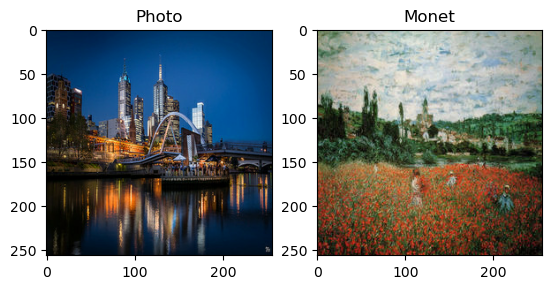

In [28]:
monet_ds = load_dataset(MONET_PATHS, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_PATHS, labeled=True).batch(1)
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
# [-1, 1] -> [0, 1]
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

## Histogram distribution

histogram distribution of the colors of monet image

In [29]:
# Function that will display a histogram distribution of the colors of 
# a particular image in the dataset
def color_hist_visualization(image_path, figsize=(16, 4)):
    plt.figure(figsize=figsize)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.axis("off")
    
    colors = ["red", "green", "blue"]
    for i in range(len(colors)):
        plt.subplot(1, 4, i + 2)
        plt.hist(
            img[:, :, i].reshape(-1),
            bins=25,
            alpha=0.5,
            color=colors[i],
            density=True
        )
        plt.xlim(0, 255)
        plt.xticks([])
        plt.yticks([])
    plt.show()

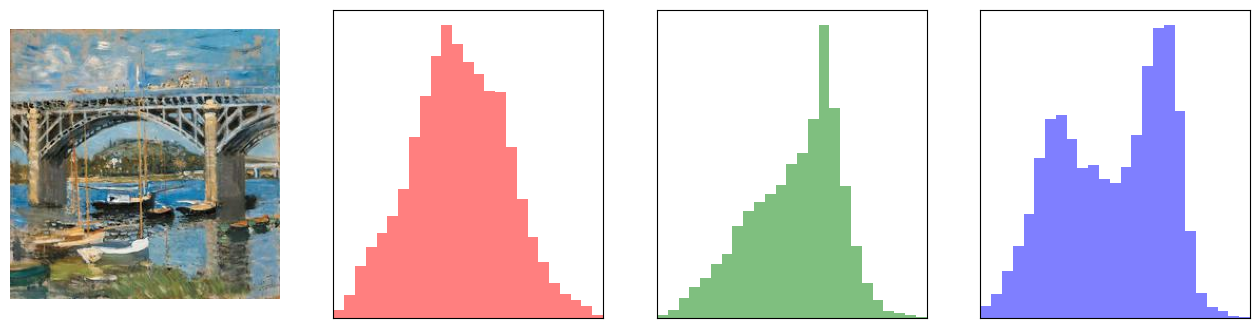

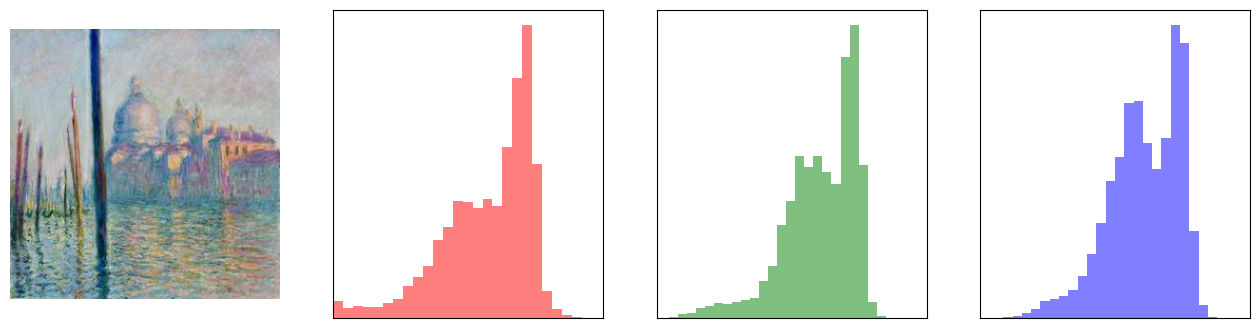

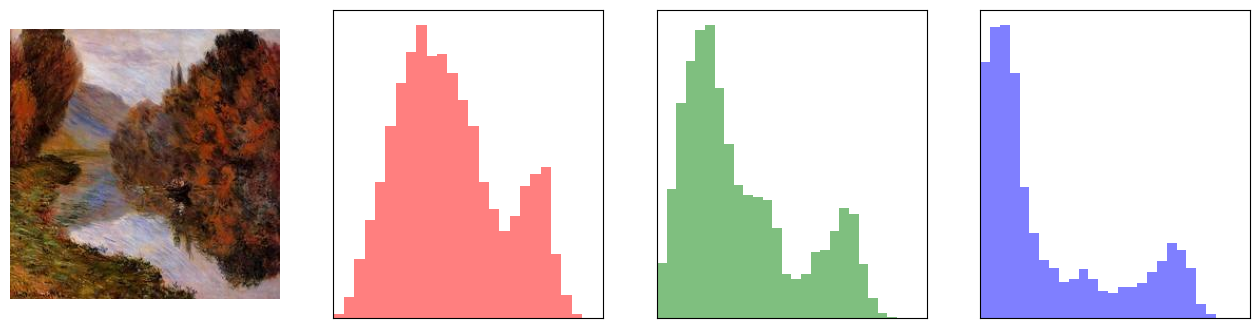

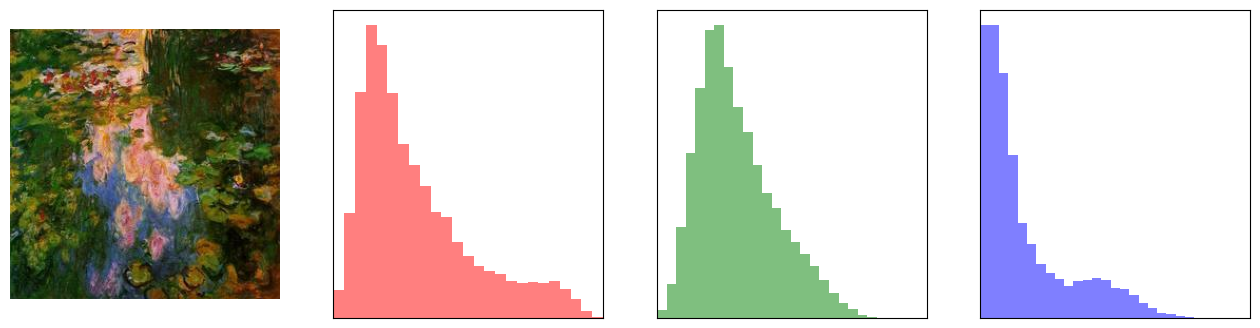

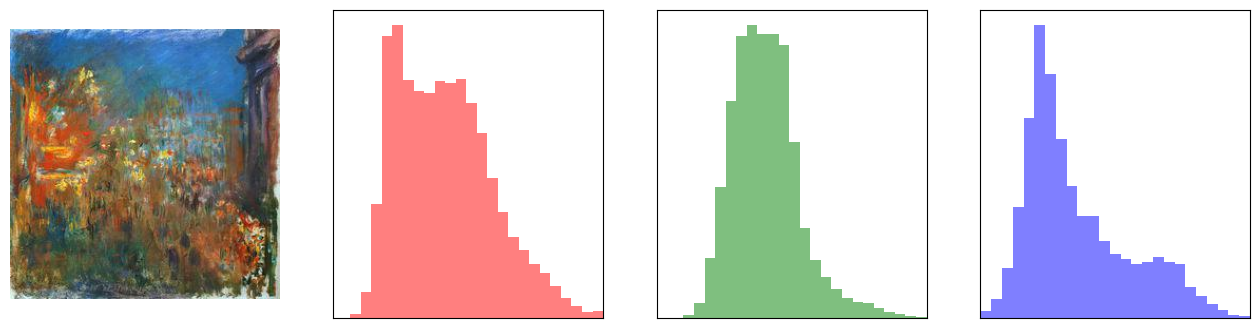

In [31]:
# Visualizing the color distribution of some of the dataset images
color_hist_visualization("../gan-getting-started/monet_jpg/10c555c1b1.jpg")
color_hist_visualization("../gan-getting-started/monet_jpg/19dc36ccb2.jpg")
color_hist_visualization("../gan-getting-started/monet_jpg/b3adc75e7d.jpg")
color_hist_visualization("../gan-getting-started/monet_jpg/f7836c88eb.jpg")
color_hist_visualization("../gan-getting-started/monet_jpg/d4116437bb.jpg")

# Split the Data to CycleGAN Format